In [1]:
# Install TensorFlow 1.15.0.
!pip install tensorflow==2.12.0

Defaulting to user installation because normal site-packages is not writeable
distutils: /basksir/vhome/mmakiela/.local/lib/python3.9/site-packages
sysconfig: /basksir/vhome/mmakiela/.local/lib64/python3.9/site-packages
user = True
home = None
root = None
prefix = None


In [21]:
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

train_images = np.load("k49-train-imgs.npz")['arr_0']
train_labels = np.load("k49-train-labels.npz")['arr_0']
test_images = np.load("k49-test-imgs.npz")['arr_0']
test_labels = np.load("k49-test-labels.npz")['arr_0']

In [22]:
from sklearn.model_selection import train_test_split

# Combine train and test datasets
all_images = np.concatenate((train_images, test_images), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

print(f"Images shape: {all_images.shape}")  # e.g., (num_samples, 48, 48)
print(f"Labels shape: {all_labels.shape}")  

Images shape: (270912, 28, 28)
Labels shape: (270912,)


In [23]:
!pip install scikit-learn
from sklearn.model_selection import train_test_split

train_images, validation_images, train_labels, validation_labels = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42
)

test_images, validation_images, test_labels, validation_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42
)

Defaulting to user installation because normal site-packages is not writeable
distutils: /basksir/vhome/mmakiela/.local/lib/python3.9/site-packages
sysconfig: /basksir/vhome/mmakiela/.local/lib64/python3.9/site-packages
user = True
home = None
root = None
prefix = None


In [24]:
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)
validation_images = validation_images.reshape(-1, 28, 28, 1)
shape = (28,28,1)

In [25]:
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Testing images shape: {test_images.shape}")
print(f"Testing labels shape: {test_labels.shape}")
print(f"Validation images shape: {validation_images.shape}")
print(f"validation labels shape: {validation_labels.shape}")

Training images shape: (189638, 28, 28, 1)
Training labels shape: (189638,)
Testing images shape: (19273, 28, 28, 1)
Testing labels shape: (19273,)
Validation images shape: (19274, 28, 28, 1)
validation labels shape: (19274,)


In [26]:
train_images = train_images / 255.0
test_images = test_images / 255.0
validation_images = validation_images / 255.0

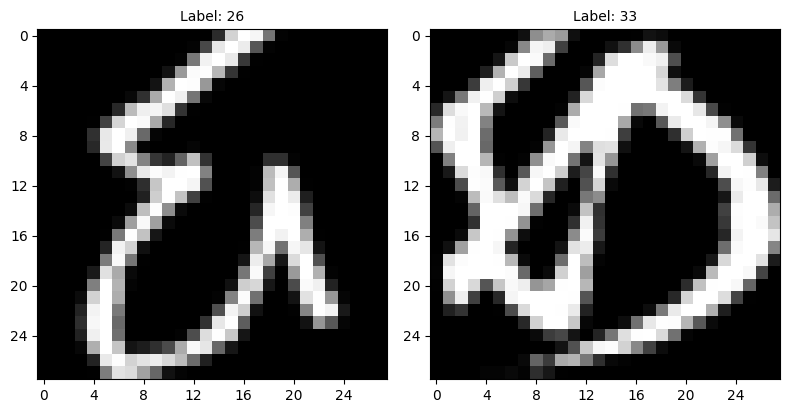

In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

j = 44
for i, ax in enumerate(axes):
    ax.imshow(train_images[i+j], cmap='gray') 
    ax.set_xticks(range(0, 28, 4))
    ax.set_yticks(range(0, 28, 4))
    ax.set_title(f"Label: {train_labels[i+j]}", fontsize=10) 

plt.tight_layout()
plt.savefig('k49_example_characters.png')
plt.show()

In [28]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

datagen.fit(train_images)

In [29]:
model = keras.Sequential([
    keras.layers.ZeroPadding2D(3, input_shape=shape),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.ZeroPadding2D(1),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(49, activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_2 (ZeroPaddi  (None, 34, 34, 1)        0         
 ng2D)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 zero_padding2d_3 (ZeroPaddi  (None, 18, 18, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

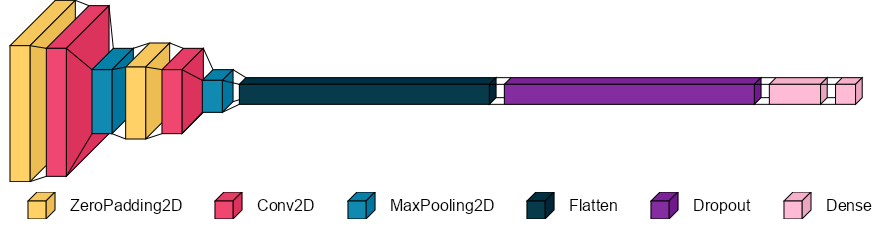

In [31]:
import visualkeras
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 16, encoding="unic")

visualkeras.layered_view(
    model,
    legend=True,
    font=font,
    spacing=15,
    max_z=250,
    to_file='architecture_k49.png'
)

In [32]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=7,             
    restore_best_weights=True, 
    verbose=1,
)

history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    validation_data=(validation_images, validation_labels),
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50


2025-01-01 12:14:31.557275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5927/5927 [==============================] - 43s 7ms/step - loss: 0.7444 - accuracy: 0.7939 - val_loss: 0.3609 - val_accuracy: 0.9015
Epoch 2/50
5927/5927 [==============================] - 43s 7ms/step - loss: 0.3891 - accuracy: 0.8891 - val_loss: 0.2442 - val_accuracy: 0.9320
Epoch 3/50
5927/5927 [==============================] - 43s 7ms/step - loss: 0.3223 - accuracy: 0.9075 - val_loss: 0.1992 - val_accuracy: 0.9470
Epoch 4/50
5927/5927 [==============================] - 43s 7ms/step - loss: 0.2877 - accuracy: 0.9172 - val_loss: 0.2007 - val_accuracy: 0.9463
Epoch 5/50
5927/5927 [==============================] - 43s 7ms/step - loss: 0.2640 - accuracy: 0.9236 - val_loss: 0.1797 - val_accuracy: 0.9516
Epoch 6/50
5927/5927 [==============================] - 43s 7ms/step - loss: 0.2482 - accuracy: 0.9279 - val_loss: 0.1650 - val_accuracy: 0.9546
Epoch 7/50
5927/5927 [==============================] - 43s 7ms/step - loss: 0.2366 - accuracy: 0.9307 - val_loss: 0.1826 - val_accuracy: 0.9

In [34]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Accuracy: {test_accuracy * 100:.2f}%")
print(f"Loss: {test_loss}")

603/603 [==============================] - 1s 2ms/step - loss: 0.0913 - accuracy: 0.9750
Accuracy: 97.50%
Loss: 0.09128694236278534


In [36]:
model.save("k49_model.h5")

In [37]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
distutils: /basksir/vhome/mmakiela/.local/lib/python3.9/site-packages
sysconfig: /basksir/vhome/mmakiela/.local/lib64/python3.9/site-packages
user = True
home = None
root = None
prefix = None


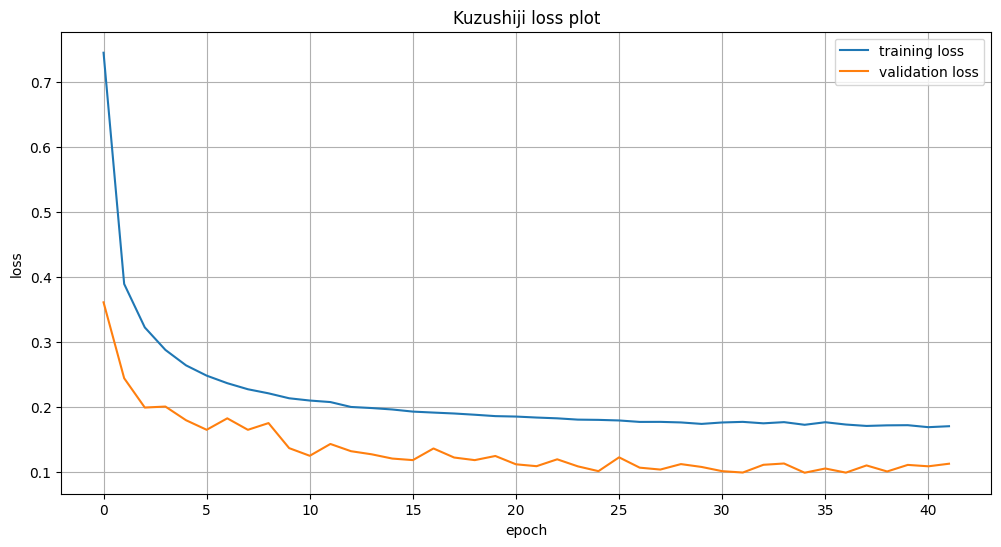

In [38]:
import matplotlib.pyplot as plt

# plot loss
fig = plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Kuzushiji loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
ax = fig.gca()
ax.set_xticks(np.arange(0, 42, 5))
plt.grid()
plt.legend()
plt.savefig('loss_k49.png')
plt.show()
plt.close()

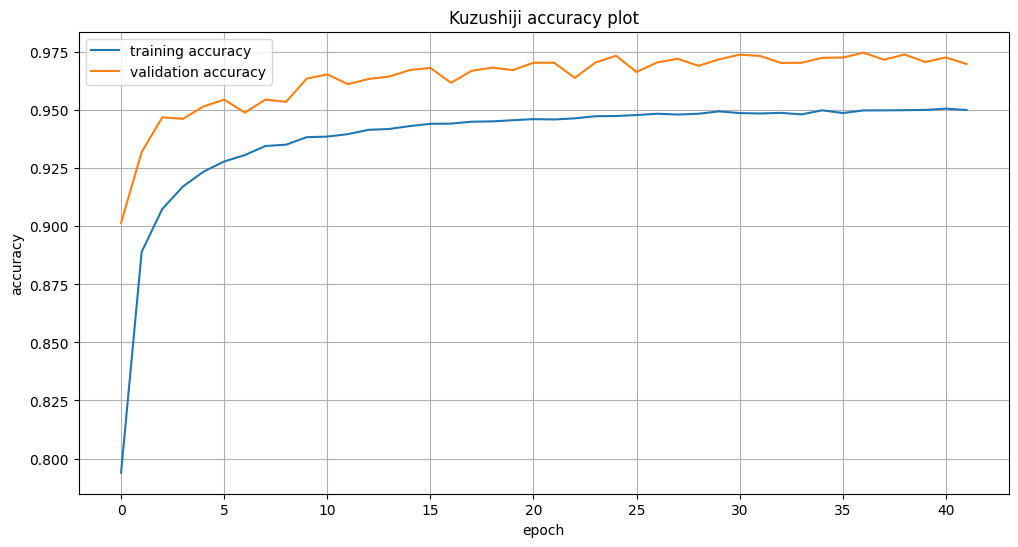

In [39]:
# plot accuracy
fig = plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Kuzushiji accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
ax = fig.gca()
ax.set_xticks(np.arange(0, 42, 5))
plt.grid()
plt.savefig('accuracy_k49.png')
plt.show()
plt.close()